# SIR ABM models with Mesa

* https://www.youtube.com/watch?v=lcySLoprPMc&t=202s
* https://github.com/projectmesa/mesa/wiki/Mesa-Packages

In [1]:
import time
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # `compute_gini` defined above
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [2]:
st=time.time()
model = MoneyModel(1000, 20, 20)
for i in range(100):
    model.step()
print (time.time()-st)

2.0573837757110596


In [3]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

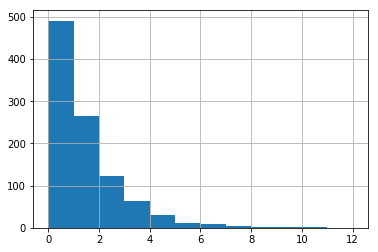

In [4]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

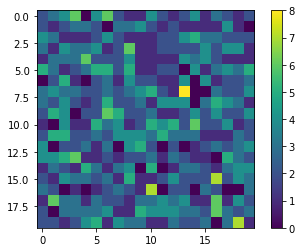

In [6]:
import numpy as np
import pylab as plt

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [7]:
from mesa.batchrunner import BatchRunner


In [8]:
fixed_params = {
    "width": 10,
    "height": 10
}

variable_params = {"N": range(10, 500, 10)}

# The variables parameters will be invoke along with the fixed parameters allowing for either or both to be honored.
batch_run = BatchRunner(
    MoneyModel,
    variable_params,
    fixed_params,
    iterations=5,
    max_steps=100,
    model_reporters={"Gini": compute_gini}
)

batch_run.run_all()

245it [02:08,  1.00s/it]


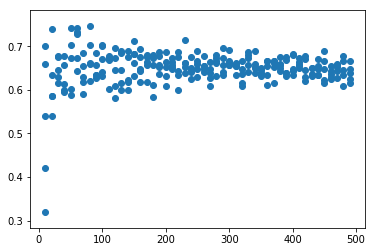

In [9]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)

## Mesa-SIR

In [30]:
#!pip install mesa_SIR
!pip install mesa-SIR
from mesa_SIR import SIR

In [26]:
!pip install git+https://github.com/metalcorebear/Mesa-SIR.git

  Cloning https://github.com/metalcorebear/Mesa-SIR.git to /tmp/pip-req-build-r4bo6wky
  Running setup.py bdist_wheel for mesa-SIR ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-tmd42aqi/wheels/01/ff/fb/c8dc34333af8459429d164c6ca4e606aee095f6f4fd10a1120
Successfully built mesa-SIR


In [31]:
interactions = 10
population = 100

In [33]:
# returns a networkx graph to place in your Mesa NetworkGrid instance
G = SIR.build_network(interactions, population)
self.grid = NetworkGrid(G)


NameError: name 'NetworkGrid' is not defined

In [18]:
SIR.

SyntaxError: invalid syntax (<ipython-input-18-27a4d20b8e4a>, line 1)

In [19]:
SIR_instance = SIR.Infection(ptrans = 0.40,
                                      reinfection_rate = 0.10,
                                      I0= 0.02,
                                      severe = 0.90,
                                      progression_period = 5,
                                      progression_sd = 2,
                                      death_rate = 0.30,
                                      recovery_days = 38,
                                      recovery_sd = 6)

TypeError: __init__() missing 1 required positional argument: 'model'

In [38]:
?SIR.Infection

Init signature: SIR.Infection(model, ptrans=0.25, reinfection_rate=0.0, I0=0.1, severe=0.18, progression_period=3, progression_sd=2, death_rate=0.0193, recovery_days=21, recovery_sd=7)
Docstring:      <no docstring>
File:           /usr/local/lib/python3.7/dist-packages/mesa_SIR/SIR.py
Type:           type


## Mesa GEO